# Interpretability Methods
## Examples of the interpretability methods run on an example image and InceptionV3.

In [1]:
%load_ext autoreload
%autoreload 2

In [29]:
import torch
import torchvision.models as models
import torchvision.transforms as transforms
import numpy as np
import PIL.Image
import matplotlib.pyplot as plt
import json

from interpretability_methods.vanilla_gradients import VanillaGradients
from interpretability_methods.integrated_gradients import IntegratedGradients
from interpretability_methods.guided_backprop import GuidedBackprop
from interpretability_methods.input_x_gradient import InputXGradient
from interpretability_methods.gradcam import GradCAM
from interpretability_methods.guided_gradcam import GuidedGradCAM
from interpretability_methods.gradient_shap import GradientSHAP
from interpretability_methods.xrai import XRAI
from interpretability_methods.lime_method import LIME
from interpretability_methods.rise import RISE
from interpretability_methods.sis import SIS

from interpretability_methods.util import visualize_saliency

## Load model and image
We load a pretrained Inception V3 from PyTorch and a sample image from dist. We create a batch using transformed versions of the image. The model correctly predicts both images to be a Doberman.

In [5]:
# Load Inception V3 Model
def load_model_from_pytorch(architecture, pretrained=True):
    model = models.__dict__[architecture](pretrained=pretrained)
    return model 
MODEL = load_model_from_pytorch('inception_v3', pretrained=True).cuda().eval()

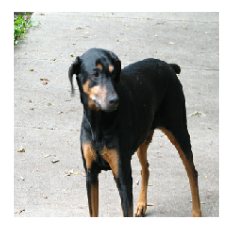

In [6]:
# Load Test Image
def load_image(file_path):
    im = PIL.Image.open(file_path)
    im = np.asarray(im)
    return im / 127.5 - 1.0 # normalize -1 to 1 for inception

def show_image(im, ax=None):
    if ax is None:
        _, ax = plt.subplots(nrows=1, ncols=1)
    ax.axis('off')
    im = ((im + 1) * 127.5).astype(np.uint8)
    ax.imshow(im)
    
def show_batch(batch):
    batch_size = batch.shape[0]
    fig, axes = plt.subplots(nrows=1, ncols=batch_size)
    for i, image in enumerate(batch):
        show_image(image, axes[i])
    
IMAGE = load_image('./doberman.png')
show_image(IMAGE)

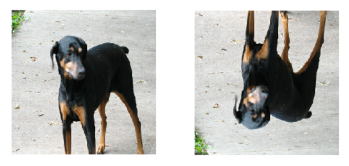

In [7]:
# Make Test Image Batch
input_instance = torch.from_numpy(IMAGE.transpose(2, 0, 1)).cuda().float()[:3, :, :]
input_instance_flipped = torch.from_numpy(np.flip(IMAGE.transpose(2, 0, 1), axis=1).copy()).cuda().float()[:3, :, :]
input_batch = torch.stack([input_instance, input_instance_flipped])
show_batch(input_batch.detach().cpu().numpy().transpose(0, 2, 3, 1))

In [8]:
# Predict Image Class
with open('/home/aboggust/data/imagenet/labels.json', 'r') as f:
    labels = json.load(f)
output = MODEL(input_batch)
predictions = np.argmax(output.cpu().detach().numpy(), axis=1)
for i, prediction in enumerate(predictions):
    print('Prediction %d:' %i, prediction, labels[prediction])

Prediction 0: 236 ['n02107142', 'Doberman', '236']
Prediction 1: 236 ['n02107142', 'Doberman', '236']


## Run each interpretability method.
We run each method on the image batch using the `get_saliency` and `get_saliency_smoothed` methods.

### Vanilla Gradients

/nobackup/users/aboggust/bin/miniconda3/envs/wml/lib/python3.6/site-packages/captum/_utils/gradient.py:59: UserWarning: Input Tensor 0 did not already require gradients, required_grads has been set automatically.
  "required_grads has been set automatically." % index


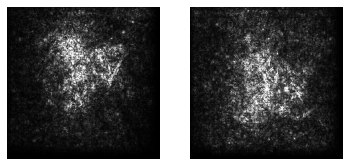

In [9]:
vanilla_gradients = VanillaGradients(MODEL)
vanilla_gradient_masks = vanilla_gradients.get_saliency(input_batch)
visualize_saliency(vanilla_gradient_masks);

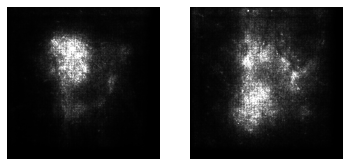

In [11]:
vanilla_gradient_smoothgrad_masks = vanilla_gradients.get_saliency_smoothed(input_batch)
visualize_saliency(vanilla_gradient_smoothgrad_masks);

### Integrated Gradients

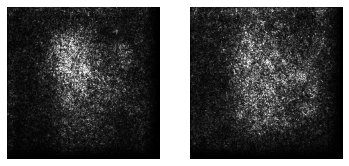

In [12]:
integrated_gradients = IntegratedGradients(MODEL)
integrated_gradient_masks = integrated_gradients.get_saliency(input_batch)
visualize_saliency(integrated_gradient_masks);

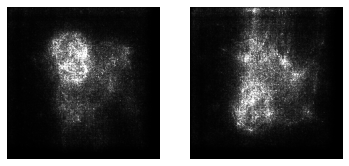

In [13]:
integrated_gradient_smoothgrad_masks = integrated_gradients.get_saliency_smoothed(input_batch)
visualize_saliency(integrated_gradient_smoothgrad_masks);

### Guided BackProp

/nobackup/users/aboggust/bin/miniconda3/envs/wml/lib/python3.6/site-packages/captum/attr/_core/guided_backprop_deconvnet.py:61: UserWarning: Setting backward hooks on ReLU activations.The hooks will be removed after the attribution is finished
  "Setting backward hooks on ReLU activations."


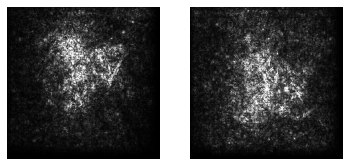

In [14]:
guided_backprop = GuidedBackprop(MODEL)
guided_backprop_masks = guided_backprop.get_saliency(input_batch)
visualize_saliency(guided_backprop_masks);

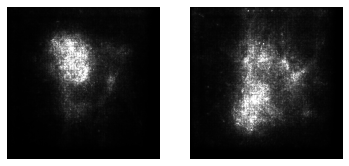

In [18]:
guided_backprop_smoothgrad_masks = guided_backprop.get_saliency_smoothed(input_batch)
visualize_saliency(guided_backprop_smoothgrad_masks);

### Input X Gradient

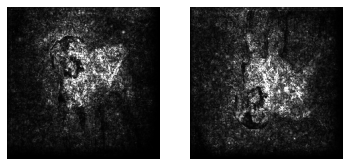

In [19]:
input_x_gradient = InputXGradient(MODEL)
input_x_gradient_masks = input_x_gradient.get_saliency(input_batch)
visualize_saliency(input_x_gradient_masks);

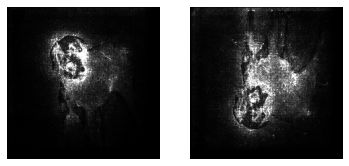

In [20]:
input_x_gradient_smoothgrad_masks = input_x_gradient.get_saliency_smoothed(input_batch)
visualize_saliency(input_x_gradient_smoothgrad_masks);

### GradCAM

/nobackup/users/aboggust/bin/miniconda3/envs/wml/lib/python3.6/site-packages/torch/nn/functional.py:2494: UserWarning: Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  "See the documentation of nn.Upsample for details.".format(mode))


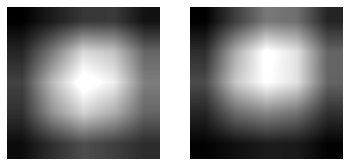

In [21]:
gradcam = GradCAM(MODEL, MODEL.Mixed_7c)
gradcam_masks = gradcam.get_saliency(input_batch)
visualize_saliency(gradcam_masks);

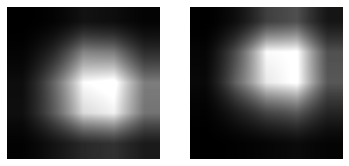

In [22]:
gradcam_smoothgrad_masks = gradcam.get_saliency_smoothed(input_batch)
visualize_saliency(gradcam_smoothgrad_masks);

### Guided GradCAM

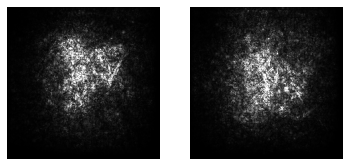

In [23]:
guided_gradcam = GuidedGradCAM(MODEL, MODEL.Mixed_7c)
guided_gradcam_masks = guided_gradcam.get_saliency(input_batch)
visualize_saliency(guided_gradcam_masks);

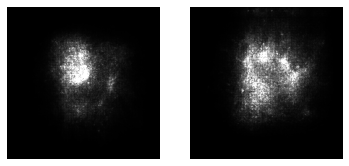

In [24]:
guided_gradcam_smoothgrad_masks = guided_gradcam.get_saliency_smoothed(input_batch)
visualize_saliency(guided_gradcam_smoothgrad_masks);

### Gradient SHAP

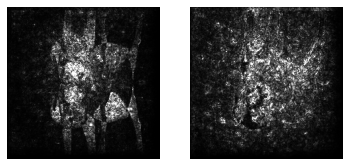

In [25]:
gradient_shap = GradientSHAP(MODEL)
gradient_shap_masks = gradient_shap.get_saliency(input_batch)
visualize_saliency(gradient_shap_masks);

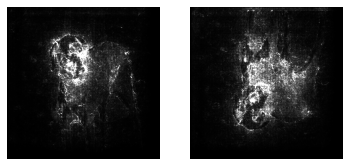

In [26]:
gradient_shap_smoothgrad_masks = gradient_shap.get_saliency_smoothed(input_batch)
visualize_saliency(gradient_shap_smoothgrad_masks);

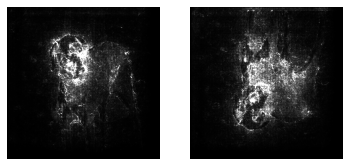

In [26]:
gradient_shap_smoothgrad_masks = gradient_shap.get_saliency_smoothed(input_batch)
visualize_saliency(gradient_shap_smoothgrad_masks);

### XRAI

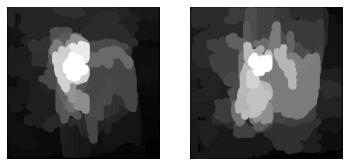

In [27]:
xrai = XRAI(MODEL)
xrai_masks = xrai.get_saliency(input_batch)
visualize_saliency(xrai_masks);

### LIME

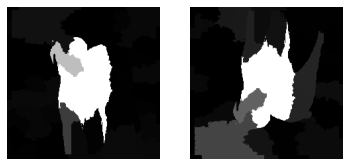

In [30]:
lime = LIME(MODEL)
lime_masks = lime.get_saliency(input_batch)
visualize_saliency(lime_masks);

### RISE

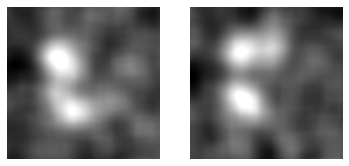

In [31]:
input_size = tuple(input_batch[0].shape)[1:]
rise = RISE(MODEL, input_size)
rise_masks = rise.get_saliency(input_batch)
visualize_saliency(rise_masks);

### SIS

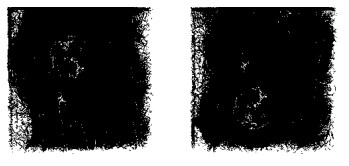

In [32]:
sis = SIS(MODEL)
sis_masks = sis.get_saliency(input_batch)
visualize_saliency(sis_masks);